<a href="https://colab.research.google.com/github/anoldKupara/Machine-Learning-Course/blob/main/Time_Series_Forecasting_Covid_19_Recovered.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np # linear algebra
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings("ignore")# data processing, CSV file I/O (e.g. pd.read_csv)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
series=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Datasets/covid_19_clean_complete.csv")

In [4]:
cases = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/day_wise.csv')

In [5]:
cases.head()

,Date,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,No. of countries
0,2020-01-22,555,17,28,510,0,0,0,3.06,5.05,60.71,6
1,2020-01-23,654,18,30,606,99,1,2,2.75,4.59,60.00,8
2,2020-01-24,941,26,36,879,287,8,6,2.76,3.83,72.22,9
3,2020-01-25,1434,42,39,1353,493,16,3,2.93,2.72,107.69,11
4,2020-01-26,2118,56,52,2010,684,14,13,2.64,2.46,107.69,13


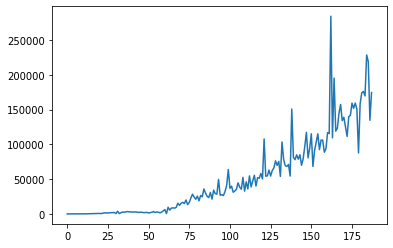

In [6]:
cases['New recovered'].plot()

In [7]:
cases.head()

,Date,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,No. of countries
0,2020-01-22,555,17,28,510,0,0,0,3.06,5.05,60.71,6
1,2020-01-23,654,18,30,606,99,1,2,2.75,4.59,60.00,8
2,2020-01-24,941,26,36,879,287,8,6,2.76,3.83,72.22,9
3,2020-01-25,1434,42,39,1353,493,16,3,2.93,2.72,107.69,11
4,2020-01-26,2118,56,52,2010,684,14,13,2.64,2.46,107.69,13


In [8]:
import matplotlib.pyplot as plt

In [9]:
#Forecasting the Covid-19 Situation around the World (Generalised Model Globally)

cases.isnull().sum()

Date                      0
Confirmed                 0
Deaths                    0
Recovered                 0
Active                    0
New cases                 0
New deaths                0
New recovered             0
Deaths / 100 Cases        0
Recovered / 100 Cases     0
Deaths / 100 Recovered    0
No. of countries          0
dtype: int64

In [10]:
cases.shape

(188, 12)

In [11]:
recovered = cases[['Date','New recovered']]

In [12]:
recovered['Date'].min(),series['Date'].max()

('2020-01-22', '2020-07-27')

In [13]:
recov=recovered.loc[(recovered['Date']>'2020-05-16' )& (recovered['Date'] < '2020-07-15')].copy()

In [14]:
recov=recov.groupby('Date')['New recovered'].sum().reset_index()

In [15]:
recov.head()

,Date,New recovered
0,2020-05-17,40153
1,2020-05-18,52210
2,2020-05-19,51347
3,2020-05-20,58185
4,2020-05-21,50327


In [16]:
rtoll = recov.copy()

In [17]:
rtoll.head()

,Date,New recovered
0,2020-05-17,40153
1,2020-05-18,52210
2,2020-05-19,51347
3,2020-05-20,58185
4,2020-05-21,50327


In [18]:
rtoll.set_index('Date',inplace=True)

In [19]:
rtoll.index = pd.to_datetime(rtoll.index)

In [20]:
rtoll.head()

,New recovered
Date,
2020-05-17,40153
2020-05-18,52210
2020-05-19,51347
2020-05-20,58185
2020-05-21,50327


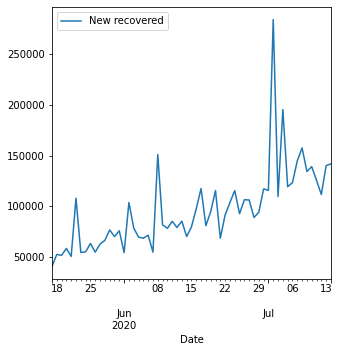

In [21]:
from pylab import rcParams
rcParams['figure.figsize'] =5,5
rtoll.plot()

In [22]:
from statsmodels.tsa.stattools import adfuller

In [23]:
test_results = adfuller(rtoll['New recovered'])

In [24]:
#Ho: It is Not Stattionary
#HA : It is Stationary

def adfuller_test (deaths):
    result = adfuller(deaths)
    labels=['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+':'+ str(value))
    if(result[1]<=0.05):
        print("Stationary")
    else:
        print("Not Stationary")

In [25]:
adfuller_test(rtoll['New recovered'])

ADF Test Statistic:-2.3399398776581304
p-value:0.15940983099958272
#Lags Used:1
Number of Observations Used:57
Not Stationary


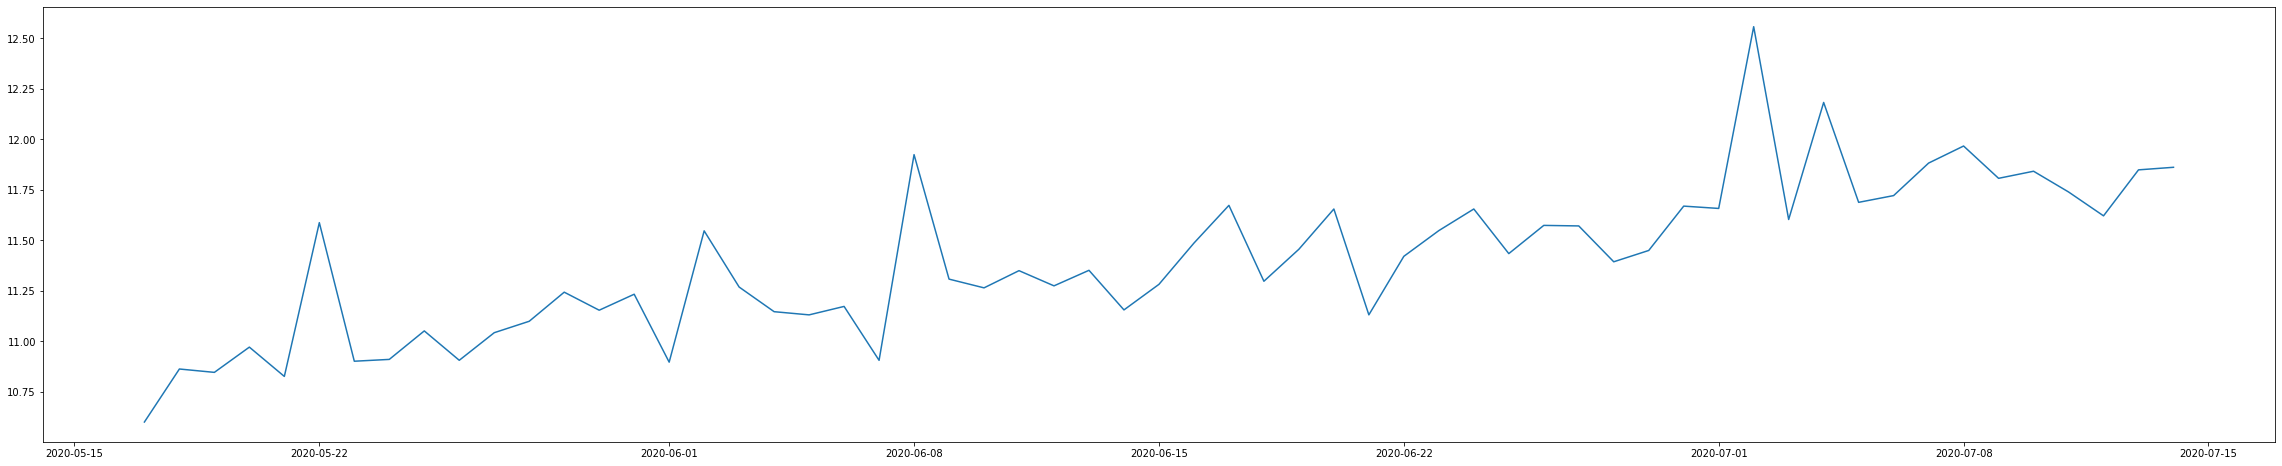

In [26]:
#Differencing Used To Make Data Stationary

plt.figure(figsize=(40,8))
plt.plot(np.log(rtoll['New recovered']))

In [27]:
rtoll['New recovered Diff'] = rtoll['New recovered']-rtoll['New recovered'].shift(1)

In [28]:
adfuller_test(rtoll['New recovered Diff'].dropna())

ADF Test Statistic:-6.092919544873868
p-value:1.0261885233294918e-07
#Lags Used:4
Number of Observations Used:53
Stationary


In [29]:
rtoll.isnull().sum()

New recovered         0
New recovered Diff    1
dtype: int64

In [30]:
rtoll.drop(['New recovered'],axis=1,inplace=True)

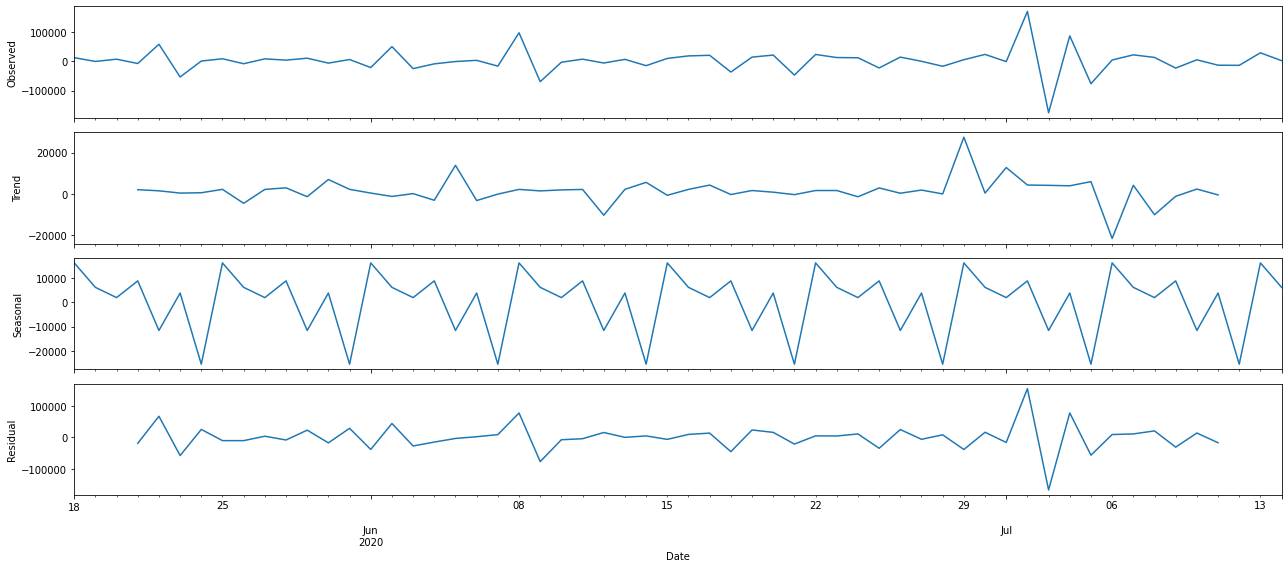

In [31]:
#**As you can see that the data has become stationary after differencing**

from pylab import rcParams 
rcParams['figure.figsize'] =18,8
decomposition = sm.tsa.seasonal_decompose(rtoll.dropna(),model='additive')
fig = decomposition.plot()
plt.show()

In [32]:
rtoll.head()

,New recovered Diff
Date,
2020-05-17,NaN
2020-05-18,12057.0
2020-05-19,-863.0
2020-05-20,6838.0
2020-05-21,-7858.0


In [33]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

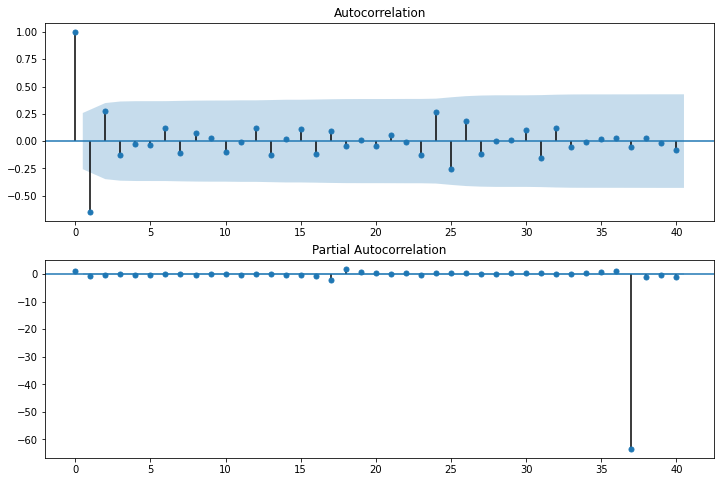

In [34]:
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(rtoll['New recovered Diff'].iloc[1:],lags=40,ax=ax1)
ax2=fig.add_subplot(212)
fig=sm.graphics.tsa.plot_pacf(rtoll['New recovered Diff'].iloc[1:],lags=40,ax=ax2)

In [35]:
from statsmodels.tsa.arima_model import ARIMA

In [36]:
p = q = d = range(0,2)
pdq = list(itertools.product(p,d,q))

In [37]:
for param in pdq:
        try:
            model=ARIMA(rtoll['New recovered Diff'].dropna(),order=param)
            results=model.fit()
            print('ARIMA{}- AIC:{}'.format(param,results.aic))
        except:
            continue

ARIMA(0, 0, 0)- AIC:1406.1326894323236
ARIMA(0, 0, 1)- AIC:1365.8018981360456
ARIMA(0, 1, 0)- AIC:1450.837953657275
ARIMA(0, 1, 1)- AIC:nan
ARIMA(1, 0, 0)- AIC:1377.3280305269634
ARIMA(1, 1, 0)- AIC:1400.1239320980749


In [38]:
model = ARIMA(rtoll['New recovered Diff'].dropna(),order=(0,0,1))

In [39]:
results=model.fit()

In [40]:
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,1676.9224,220.221,7.615,0.000,1245.297,2108.547
ma.L1.New recovered Diff,-1.0000,0.055,-18.032,0.000,-1.109,-0.891


In [41]:
rtoll['Forecast']=results.predict(start=pd.to_datetime('2020-07-01'),dynamic=False)

In [42]:
rtoll['Forecast'].tail(5)

Date
2020-07-10     4796.050070
2020-07-11     1676.971519
2020-07-12    16641.805101
2020-07-13    31775.257196
2020-07-14     4893.744086
Name: Forecast, dtype: float64

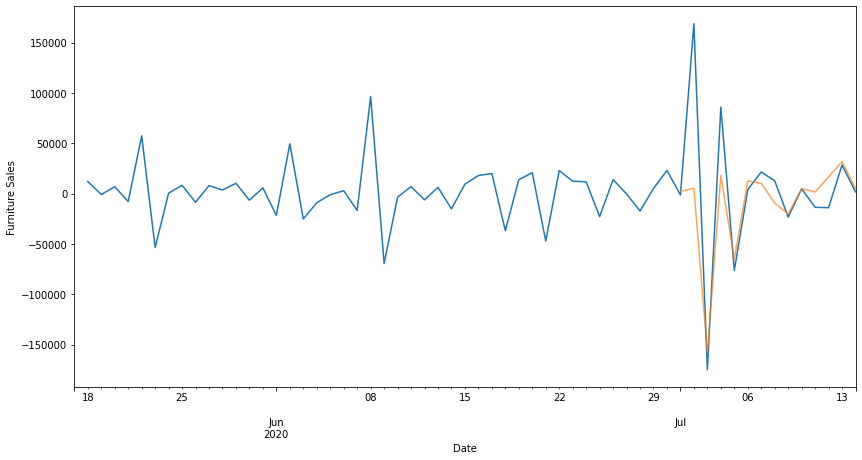

In [43]:
ax=rtoll['New recovered Diff'].plot(label='Observed')
rtoll['Forecast'].plot(ax=ax,label='Predicted',alpha=.7,figsize=(14,7))
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.show()

In [44]:
rtoll.index[-1]

Timestamp('2020-07-14 00:00:00')

In [45]:
#Getting the forecasted value for the next seven days
forecast = results.forecast(steps=7)[0]

In [46]:
forecast

array([4777.66623594, 1676.92235944, 1676.92235944, 1676.92235944,
       1676.92235944, 1676.92235944, 1676.92235944])

In [47]:
from pandas.tseries.offsets import DateOffset
future_dates = [rtoll.index[-1]+ DateOffset(days=x)for x in range(0,7)]

In [48]:
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=rtoll.columns)

In [49]:
future_df = pd.concat([rtoll,future_dates_df])

In [50]:
future_df.tail(6)

,New recovered Diff,Forecast
2020-07-15,NaN,NaN
2020-07-16,NaN,NaN
2020-07-17,NaN,NaN
2020-07-18,NaN,NaN
2020-07-19,NaN,NaN
2020-07-20,NaN,NaN


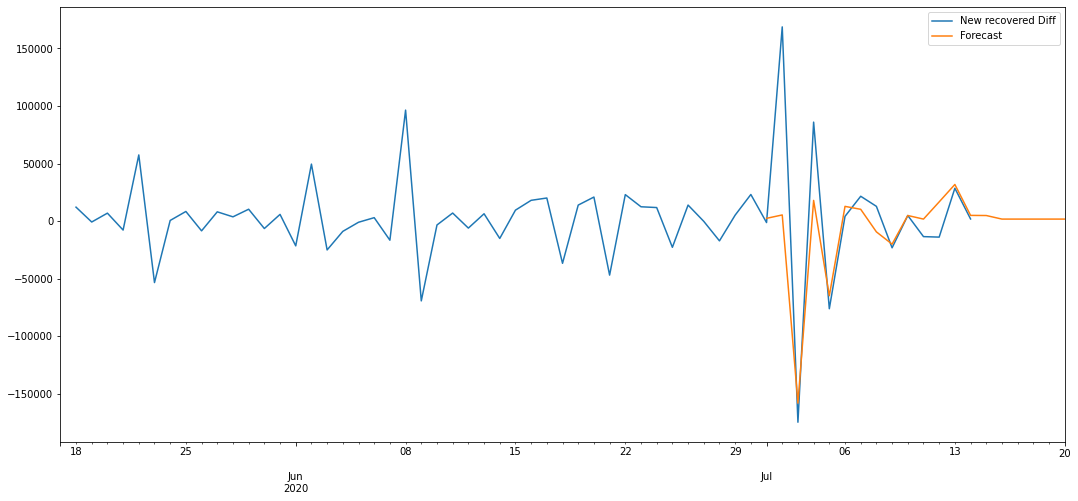

In [51]:
future_df['Forecast'] = results.predict(start='2020-07-01',end='2020-07-20',dynamic=False)
future_df[['New recovered Diff','Forecast']].plot()